<h3> General Forecasting Methods </h3>

<b> Forecasting Procedure: </b> 

 - Choose Model (through statistical analysis)
 - Split data into train and test sets (for fairly evaluate our model)
 - Fit model on training set
 - Evaluate model on test set
 - Refit model on etire dataset
 - Forecast for future dataset

<b> Section Overview: </b> 

 - Forecasting
 - ACF and PACF plots
 - Autoregression - AR
 - Descriptive Statistics and Tests
 - Choosing ARIMA orders
 - ARIMA based models

##### ACF (AutoCorrelation Function), PACF (Partial AutoCorrelation Function)

Correlation : Measure of strength of the linear relationship between 2 variables. [-1 1]

 - -1 means strong neative relationship
 - +1 means strong positive relationship
 - 0 means weaker relationship

AutoCorrelation (Correlogram) shows correlation of the series with itself, lagged by x times itself.(yaxis = correlation, xaxis = no. of times units of lag)

We need to build AC vs Shift (i-1, i-2,....) and it starts to decrease/increase (for all possible x lag units) 

 - Gradual Decline (less correaleted as we shift more and more and bit of seasonality)
 - Sharp Drop off (sudden drop in correlation and then constant in general)

###### PACF:

Residual - Error that is not explained by linear model. 

 - So we calculate erros vs (i-1)
 - Then we calculate residuals fiited on (i-1) vs (i-2) shift
 - Then plot correlation and so on (i-3....)

In general we expect PACF to drop off quite quickly

<b> Summary : </b> ACF describes autocorrelation between an observation and another observation at a prior time step that has both direct/indirect dependence whereas PACF decribes relationship between an observation and its lag. These 2 plots can help choose order parameters for ARIMA based models. Later we will see it is much easier to implement grid search to find parameter values.

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels.api as sm

from statsmodels.tsa.stattools import acovf, acf,pacf,pacf_yw,pacf_ols


Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.


##### Goals
 * Be able to create ACF and PACF charts
 * Create these charts for multiple times series, one with seasonality and another without
 * Be able to calculate Orders PQD terms for ARIMA off these charts (highlight where they cross the x axis)
 
<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html'>stattools.acovf</a></strong><font color=black>(x[, adjusted, demean, fft, …])</font>&nbsp;Autocovariance for 1D<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html'>stattools.acf</a></strong><font color=black>(x[, unbiased, nlags, qstat, …])</font>&nbsp;&nbsp;Autocorrelation function for 1d arrays<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html'>stattools.pacf</a></strong><font color=black>(x[, nlags, method, alpha])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_yw.html'>stattools.pacf_yw</a></strong><font color=black>(x[, nlags, method])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated with non-recursive yule_walker<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_ols.html'>stattools.pacf_ols</a></strong><font color=black>(x[, nlags])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate partial autocorrelations</tt>
   
<h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html'>tsaplots.plot_acf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;Plot the autocorrelation function<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html'>tsaplots.plot_pacf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Plot the partial autocorrelation function</tt>

In [5]:
#Non stationary data (monthly data)
df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

#Stationary Data (Daily data)
df2 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [6]:
df1.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
df2.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [8]:
# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$

##### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

##### Unbiased Autocovariance
Note that the number of terms in the calculations above are decreasing.<br>Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$.

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

In [12]:
# Autocovariance

df_arr = pd.DataFrame({'a':[13,5,11,12,9]})
auto_cov = acovf(df_arr['a'])
auto_cov_unbaised = acovf(df_arr['a'],adjusted=True) #in previous version it is unbaised

print('Autocovariance is : {}'.format(auto_cov))
print('Unbaised Autocovariance is : {}'.format(auto_cov_unbaised))

Autocovariance is : [ 8.  -4.  -1.6  2.2 -0.6]
Unbaised Autocovariance is : [ 8.         -5.         -2.66666667  5.5        -3.        ]


#### Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

##### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [14]:
auto_corr = acf(df_arr['a'])
print('Autocorrelation is : {}'.format(auto_corr))

Autocorrelation is : [ 1.    -0.5   -0.2    0.275 -0.075]


##### Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

##### Partial Autocorrelation with OLS
This provides partial autocorrelations with <a href='https://en.wikipedia.org/wiki/Ordinary_least_squares'>ordinary least squares</a> (OLS) estimates for each lag instead of Yule-Walker.

In [16]:
partial_auto_corr1 = pacf_yw(df_arr['a'],nlags=4,method='mle') #mle - maximum liklihood estimation
partial_auto_corr2 = pacf_yw(df_arr['a'],nlags=4,method='adjusted') #adjusted-unbaised

partial_auto_corr3 = pacf_ols(df_arr['a'],nlags=4)
partial_auto_corr4 = pacf_ols(df_arr['a'],nlags=4,adjusted=True)

print('PACF with YLS equations (MLE) is : {}'.format(partial_auto_corr1))
print('PACF with YLS equations (Unbaised) is : {}'.format(partial_auto_corr2))
print('PACF with OLS equations is : {}'.format(partial_auto_corr3))
print('PACF with OLS equations (Unbaised) is : {}'.format(partial_auto_corr4))

PACF with YLS equations (MLE) is : [ 1.         -0.5        -0.6        -0.38541667 -0.40563273]
PACF with YLS equations (Unbaised) is : [ 1.         -0.625      -1.18803419  2.03764205  0.8949589 ]
PACF with OLS equations is : [ 1.         -0.49677419 -0.43181818  0.53082621  0.25434783]
PACF with OLS equations (Unbaised) is : [ 1.         -0.62096774 -0.71969697  1.32706552  1.27173913]


### Analysis on stationary and non-stationary dataset

The arrays returned by .acf(df) and .pacf_yw(df) show the magnitude of the autocorrelation for a given 𝑦 at time 𝑡

Pandas has a built-in plotting function that plots increasing 𝑦𝑡
values on the horizontal axis against lagged versions of the values 𝑦𝑡+1 on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. 

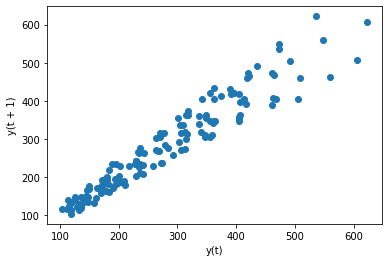

In [17]:
from pandas.plotting import lag_plot

lag_plot(df1['Thousands of Passengers']);

Very strong autocorrelation

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

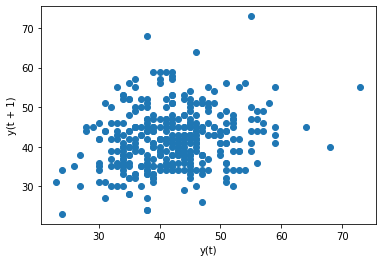

In [18]:
lag_plot(df2['Births'])

Not much correlation here as we dn't much compare the births current day with respec to previous day. But in airline datat due to seasonality effect, we can see certain trends going in positive correlation.

##### ACF Plots & PACF Plots

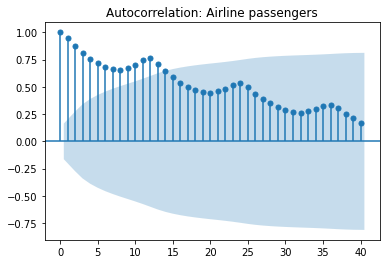

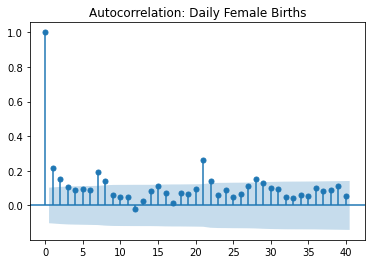

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(df1,lags=40,title='Autocorrelation: Airline passengers');
#every step size is lags, generally there are 144 steps but we will take 40 on a simpler side

plot_acf(df2,lags=40,title='Autocorrelation: Daily Female Births');

<b> Plot Airlines: </b> This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off. There is seasonality of data with local maxima and minima

<b> Plot Births: </b> This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component in the ARIMA model.

Shaded region: 95% confidence value i.e. values outside this confidence interval are very highly likely to be in correlation

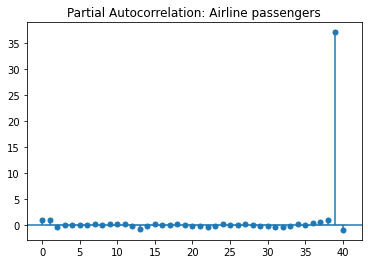

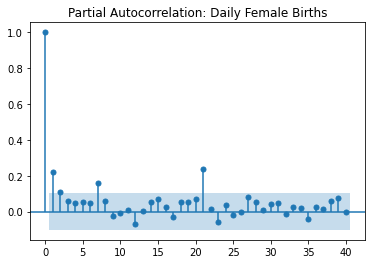

In [21]:
plot_pacf(df1,lags=40,title='Partial Autocorrelation: Airline passengers');
plot_pacf(df2,lags=40,title='Partial Autocorrelation: Daily Female Births');

PACF works good for stationary dataset as seen above

<b> It's hard to read these plots so to know order terms its better to do grid search